# Train and test AVIDNet

In [1]:
import torch
from torch.utils.data import DataLoader
import os
from torchsummary import summary
from collections import defaultdict
from datasets.transforms import get_data_transforms
from datasets.utils import separate_datasets, show_samples,CovidDataLoader
from models.model import get_model
from models.train import train_model
from models.metrics import update_mean_metrics, print_metrics


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load data

In [3]:
cfg = {
    'purpose' : 'fixmatch',
    'data_dir' : './data/CXR',
    'mu' : 4,
    'fold' : 5,
    'epochs' : 20,
    'metric_types' : ['acc', 'ppv', 'recall', 'f1']
}
dataset_types = ['train', 'test']

if not os.path.exists(os.path.join(cfg['data_dir'],'test.txt')):
    from datasets.utils import make_baseline_dataset
    make_baseline_dataset('./data/CXR',25,outpath = cfg['data_dir']) # test는 전부, train은 25개 만큼만
if not os.path.exists(os.path.join(cfg['data_dir'],'train_lb_0.txt')):
    from datasets.utils import separate_datasets
    separate_datasets('./data/CXR', cfg['fold'], 25, cfg['mu'],outpath = cfg['data_dir']) # lb는 25개, ulb는 mu*25개
                      

In [4]:
loader_test = CovidDataLoader('train', cfg, fold_id=0)
class_names = loader_test.class_names

loader_test = DataLoader(loader_test, batch_size=1, num_workers=4, shuffle=True,
                              collate_fn=loader_test.collate_fn)

In [5]:
class_names

{0: 'Covid-19', 1: 'Pneumonia', 2: 'Normal'}

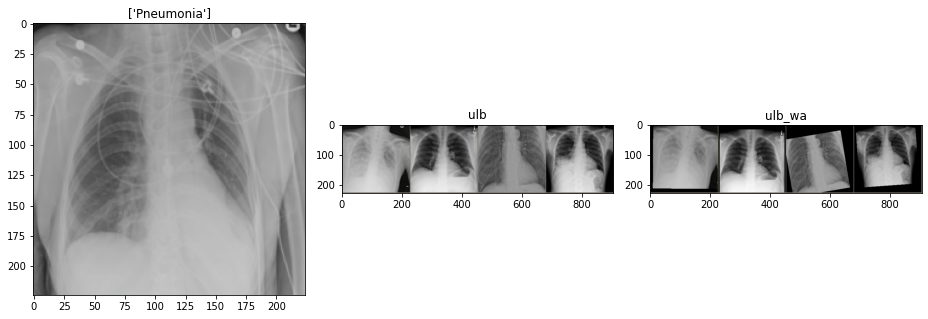

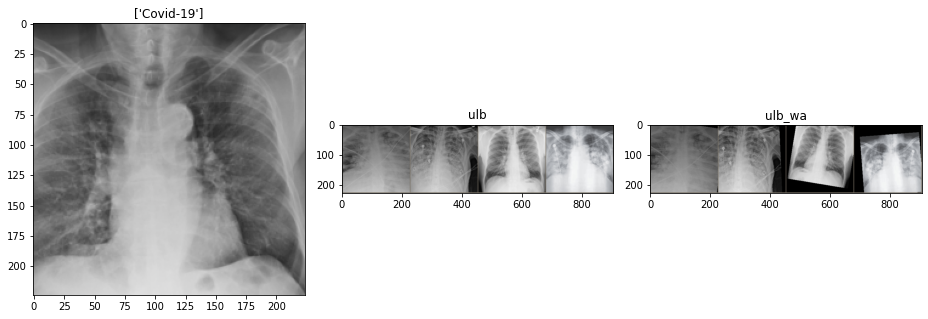

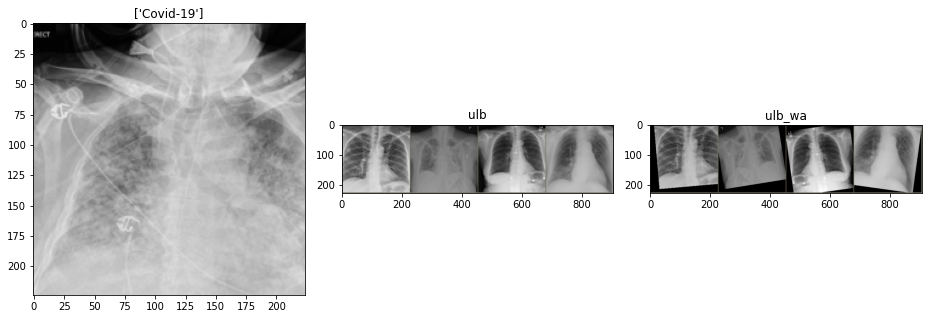

In [6]:
show_iteration = 3
show_samples(loader_test,class_names,show_iteration,cfg['mu'])

## Train the model

In [7]:
trained_models = []
cls_names = ['All', 'COVID-19', 'Pneumonia', 'Normal']

mean_metrics = {m_type: defaultdict(float) for m_type in cfg['metric_types']}
test_loader = CovidDataLoader('test', cfg)
dataset_sizes ={'test':len(test_loader)}
test_loader = DataLoader(test_loader, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=test_loader.collate_fn)
data_loaders ={'test':test_loader}


for i in range(cfg['fold']):
    train_loaders = CovidDataLoader('train', cfg,fold_id=i)
    dataset_sizes['train']=len(train_loaders)
    train_loaders = DataLoader(train_loaders, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=train_loaders.collate_fn)
    data_loaders['train']=train_loaders

    model_ft, criterion, optimizer_ft, exp_lr_scheduler = get_model(device, fine_tuning=False)
    model, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, i, cls_names,
                                 cfg['metric_types'], dataset_types, data_loaders, dataset_sizes, device, num_epochs=cfg['epochs'],
                                 lambda_u=1.0, threshold=0.95, purpose=cfg['purpose'])
    trained_models.append(model)
    mean_metrics = update_mean_metrics(cls_names, mean_metrics, metrics, status='training')

mean_metrics = update_mean_metrics(cls_names, mean_metrics, status='final', fold=cfg['fold'])
print_metrics(mean_metrics, cls_names, phase='Mean results')

--------------------
Model 1
--------------------

Epoch 0/19
----------
[train]
LOSS - 1.0790
ACC - 0.3467
PPV - All: 0.0000  COVID-19: 0.3636  Pneumonia: 0.2593  Normal: 0.4054 
RECALL - All: 0.0000  COVID-19: 0.1600  Pneumonia: 0.2800  Normal: 0.6000 
F1 - All: 0.3251  COVID-19: 0.2222  Pneumonia: 0.2693  Normal: 0.4839 
Mask ratio's range: 1.0 ~ 1.0

[test]
LOSS - 1.0611
ACC - 0.3965
PPV - All: 0.0000  COVID-19: 0.1014  Pneumonia: 0.9355  Normal: 0.7582 
RECALL - All: 0.0000  COVID-19: 0.8900  Pneumonia: 0.0488  Normal: 0.5740 
F1 - All: 0.3094  COVID-19: 0.1821  Pneumonia: 0.0928  Normal: 0.6534 

Validation loss decreased (inf --> 1.061116).

Epoch 1/19
----------
[train]
LOSS - 0.9709
ACC - 0.4800
PPV - All: 0.0000  COVID-19: 0.3714  Pneumonia: 0.5000  Normal: 0.7143 
RECALL - All: 0.0000  COVID-19: 0.5200  Pneumonia: 0.5200  Normal: 0.4000 
F1 - All: 0.4853  COVID-19: 0.4333  Pneumonia: 0.5098  Normal: 0.5128 
Mask ratio's range: 1.0 ~ 1.0

[test]
LOSS - 0.7022
ACC - 0.6916
PPV

[test]
LOSS - 0.5062
ACC - 0.8087
PPV - All: 0.0000  COVID-19: 0.8605  Pneumonia: 0.7609  Normal: 0.8386 
RECALL - All: 0.0000  COVID-19: 0.3700  Pneumonia: 0.7929  Normal: 0.8689 
F1 - All: 0.7159  COVID-19: 0.5175  Pneumonia: 0.7766  Normal: 0.8535 

EarlyStopping counter: 2 out of 5

Epoch 14/19
----------
[train]
LOSS - 0.4056
ACC - 0.9200
PPV - All: 0.0000  COVID-19: 1.0000  Pneumonia: 0.8846  Normal: 0.8846 
RECALL - All: 0.0000  COVID-19: 0.9200  Pneumonia: 0.9200  Normal: 0.9200 
F1 - All: 0.9208  COVID-19: 0.9583  Pneumonia: 0.9020  Normal: 0.9020 
Mask ratio's range: 0.9583333320915699 ~ 1.0

[test]
LOSS - 0.4978
ACC - 0.8163
PPV - All: 0.0000  COVID-19: 0.7576  Pneumonia: 0.7783  Normal: 0.8456 
RECALL - All: 0.0000  COVID-19: 0.5000  Pneumonia: 0.7862  Normal: 0.8723 
F1 - All: 0.7478  COVID-19: 0.6024  Pneumonia: 0.7822  Normal: 0.8587 

EarlyStopping counter: 3 out of 5

Epoch 15/19
----------
[train]
LOSS - 0.4477
ACC - 0.8533
PPV - All: 0.0000  COVID-19: 0.9565  Pneumon

[test]
LOSS - 0.5846
ACC - 0.7739
PPV - All: 0.0000  COVID-19: 0.7531  Pneumonia: 0.6746  Normal: 0.8774 
RECALL - All: 0.0000  COVID-19: 0.6100  Pneumonia: 0.8586  Normal: 0.7356 
F1 - All: 0.7433  COVID-19: 0.6740  Pneumonia: 0.7556  Normal: 0.8003 

EarlyStopping counter: 2 out of 5

Epoch 10/19
----------
[train]
LOSS - 0.5715
ACC - 0.7733
PPV - All: 0.0000  COVID-19: 0.9130  Pneumonia: 0.6897  Normal: 0.7391 
RECALL - All: 0.0000  COVID-19: 0.8400  Pneumonia: 0.8000  Normal: 0.6800 
F1 - All: 0.7747  COVID-19: 0.8750  Pneumonia: 0.7408  Normal: 0.7083 
Mask ratio's range: 0.9583333320915699 ~ 1.0

[test]
LOSS - 0.5741
ACC - 0.7891
PPV - All: 0.0000  COVID-19: 0.5826  Pneumonia: 0.7297  Normal: 0.8684 
RECALL - All: 0.0000  COVID-19: 0.6700  Pneumonia: 0.8182  Normal: 0.7831 
F1 - All: 0.7394  COVID-19: 0.6233  Pneumonia: 0.7714  Normal: 0.8235 

EarlyStopping counter: 3 out of 5

Epoch 11/19
----------
[train]
LOSS - 0.6675
ACC - 0.7867
PPV - All: 0.0000  COVID-19: 0.8182  Pneumon

[test]
LOSS - 0.8224
ACC - 0.6802
PPV - All: 0.0000  COVID-19: 0.2722  Pneumonia: 0.6801  Normal: 0.9187 
RECALL - All: 0.0000  COVID-19: 0.8600  Pneumonia: 0.8266  Normal: 0.5616 
F1 - All: 0.6189  COVID-19: 0.4135  Pneumonia: 0.7462  Normal: 0.6971 

EarlyStopping counter: 1 out of 5

Epoch 5/19
----------
[train]
LOSS - 0.6725
ACC - 0.7333
PPV - All: 0.0000  COVID-19: 0.8889  Pneumonia: 0.6296  Normal: 0.6667 
RECALL - All: 0.0000  COVID-19: 0.9600  Pneumonia: 0.6800  Normal: 0.5600 
F1 - All: 0.7285  COVID-19: 0.9231  Pneumonia: 0.6538  Normal: 0.6087 
Mask ratio's range: 0.9166666641831398 ~ 1.0

[test]
LOSS - 0.5564
ACC - 0.7872
PPV - All: 0.0000  COVID-19: 0.6429  Pneumonia: 0.7754  Normal: 0.8073 
RECALL - All: 0.0000  COVID-19: 0.5400  Pneumonia: 0.7323  Normal: 0.8520 
F1 - All: 0.7231  COVID-19: 0.5870  Pneumonia: 0.7532  Normal: 0.8290 

Validation loss decreased (0.561440 --> 0.556416).

Epoch 6/19
----------
[train]
LOSS - 0.4865
ACC - 0.8267
PPV - All: 0.0000  COVID-19: 

[test]
LOSS - 0.6705
ACC - 0.7650
PPV - All: 0.0000  COVID-19: 0.4315  Pneumonia: 0.6853  Normal: 0.9307 
RECALL - All: 0.0000  COVID-19: 0.6300  Pneumonia: 0.8872  Normal: 0.6983 
F1 - All: 0.6945  COVID-19: 0.5122  Pneumonia: 0.7733  Normal: 0.7979 

EarlyStopping counter: 1 out of 5

Epoch 7/19
----------
[train]
LOSS - 0.3991
ACC - 0.9333
PPV - All: 0.0000  COVID-19: 0.8889  Pneumonia: 0.9565  Normal: 0.9600 
RECALL - All: 0.0000  COVID-19: 0.9600  Pneumonia: 0.8800  Normal: 0.9600 
F1 - All: 0.9333  COVID-19: 0.9231  Pneumonia: 0.9167  Normal: 0.9600 
Mask ratio's range: 0.9166666641831398 ~ 1.0

[test]
LOSS - 0.5895
ACC - 0.8106
PPV - All: 0.0000  COVID-19: 0.5743  Pneumonia: 0.7618  Normal: 0.8762 
RECALL - All: 0.0000  COVID-19: 0.5800  Pneumonia: 0.8182  Normal: 0.8316 
F1 - All: 0.7398  COVID-19: 0.5771  Pneumonia: 0.7890  Normal: 0.8533 

EarlyStopping counter: 2 out of 5

Epoch 8/19
----------
[train]
LOSS - 0.5460
ACC - 0.8267
PPV - All: 0.0000  COVID-19: 0.8696  Pneumonia

--------------------
Model 5
--------------------

Epoch 0/19
----------
[train]
LOSS - 1.1487
ACC - 0.3467
PPV - All: 0.0000  COVID-19: 0.4000  Pneumonia: 0.2857  Normal: 0.3158 
RECALL - All: 0.0000  COVID-19: 0.5600  Pneumonia: 0.2400  Normal: 0.2400 
F1 - All: 0.3334  COVID-19: 0.4667  Pneumonia: 0.2609  Normal: 0.2727 
Mask ratio's range: 1.0 ~ 1.0

[test]
LOSS - 0.9124
ACC - 0.4022
PPV - All: 0.0000  COVID-19: 0.0000  Pneumonia: 0.3855  Normal: 0.9020 
RECALL - All: 0.0000  COVID-19: 0.0000  Pneumonia: 0.9916  Normal: 0.0520 
F1 - All: 0.2178  COVID-19: 0.0000  Pneumonia: 0.5552  Normal: 0.0983 

Validation loss decreased (inf --> 0.912377).

Epoch 1/19
----------
[train]
LOSS - 0.9873
ACC - 0.5467
PPV - All: 0.0000  COVID-19: 0.6875  Pneumonia: 0.5238  Normal: 0.5000 
RECALL - All: 0.0000  COVID-19: 0.4400  Pneumonia: 0.4400  Normal: 0.7600 
F1 - All: 0.5394  COVID-19: 0.5366  Pneumonia: 0.4783  Normal: 0.6032 
Mask ratio's range: 1.0 ~ 1.0

[test]
LOSS - 1.2202
ACC - 0.2502
PPV

### Save and load model

In [8]:
out_dir = 'trained_models/baseline'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
    
for i, model in enumerate(trained_models):
    torch.save(model, f'trained_models/baseline/baseline_model_with_fixmatch_{i}.pt')

In [10]:
trained_model = []
for i in range(cfg['fold']):
    trained_models.append(torch.load(f'trained_models/baseline/baseline_model_with_fixmatch_{i}.pt'))
    
summary(trained_models[0], (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Reference

- https://tutorials.pytorch.kr/beginner/saving_loading_models.html
- https://stackoverflow.com/questions/42480111/model-summary-in-pytorch

## Evaluate the model - WIP

In [ ]:
# def evaluate_model(model, criterion, optimizer):
#     since = time.time()
    
#     sum_acc = 0.0
#     for i in range(5):
#         print('Test {}/{}'.format(i, 5-1))
#         print('-' * 10)

#         model.eval()   # Set model to evaluate mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders['test']:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#             iter_loss = running_loss / dataset_sizes['test']
#             iter_acc = running_corrects.double() / dataset_sizes['test']

#         sum_acc += iter_acc
#         print('{}th Loss: {:.4f} Acc: {:.4f}\n'.format(
#             i, iter_loss, iter_acc))

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Mean test Acc: {:4f}'.format(sum_acc/5))

In [ ]:
# for model in trained_models:
#     evaluate_model(model, criterion, optimizer_ft)